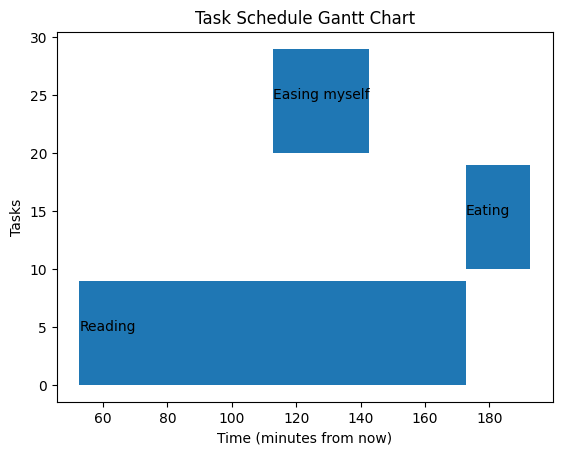

In [6]:
import tkinter as tk
from tkinter import ttk, messagebox, simpledialog
from datetime import datetime
import heapq
import matplotlib.pyplot as plt


class Task:
    """
    Represents a single task with details like description, deadline, priority, and duration.
    """
    def __init__(self, task_id, description, deadline, priority, task_type, duration):
        self.task_id = task_id
        self.description = description
        self.deadline = datetime.strptime(deadline, "%Y-%m-%d %H:%M")  # Convert deadline string to datetime
        self.priority = priority
        self.task_type = task_type  # 'personal' or 'academic'
        self.duration = duration  # in minutes

    def __lt__(self, other):
        """
        Compares tasks based on their deadlines for heap operations.
        """
        return self.deadline < other.deadline


class Scheduler:
    def __init__(self):
        self.tasks = []  # Min-heap (priority queue)

    def add_task(self, task):
        """
        Adds a task to the priority queue (min-heap) based on its deadline.
        """
        heapq.heappush(self.tasks, task)

#SORTING ALGORITHM
    def get_sorted_tasks(self, by="deadline"):
        """
        Returns a sorted list of tasks based on the specified attribute.
        """
        sorted_tasks = list(self.tasks)  # Copy heap
        if by == "deadline":
            return sorted(sorted_tasks, key=lambda x: x.deadline)
        elif by == "priority":
            return sorted(sorted_tasks, key=lambda x: x.priority, reverse=True)
        elif by == "type":
            return sorted(sorted_tasks, key=lambda x: x.task_type)
        return sorted_tasks

#SEARCHING ALGO
    def binary_search(self, task_list, target_deadline):
        """
        Searches for a task with a specific deadline using binary search.
        """
        low, high = 0, len(task_list) - 1
        while low <= high:
            mid = (low + high) // 2
            if task_list[mid].deadline == target_deadline:
                return task_list[mid]
            elif task_list[mid].deadline < target_deadline:
                low = mid + 1
            else:
                high = mid - 1
        return None

    def plot_schedule(self):
        """
        Visualizes the task schedule using a Gantt chart.
        """
        sorted_tasks = self.get_sorted_tasks()
        fig, ax = plt.subplots()
        start_time = datetime.now()

        for i, task in enumerate(self.tasks):
            start = (task.deadline - start_time).total_seconds() / 60
            ax.broken_barh([(start, task.duration)], (i * 10, 9), facecolors='tab:blue')
            ax.text(start, i * 10 + 5, f"{task.description}", va='center')

        plt.xlabel("Time (minutes from now)")
        plt.ylabel("Tasks")
        plt.title("Task Schedule Gantt Chart")
        plt.show()


class SchedulerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Personal Scheduling Assistant")
        self.scheduler = Scheduler()

        # Task Entry Frame
        self.entry_frame = tk.Frame(root)
        self.entry_frame.pack(pady=10)

        tk.Label(self.entry_frame, text="Task Description").grid(row=0, column=0)
        tk.Label(self.entry_frame, text="Deadline (YYYY-MM-DD HH:MM)").grid(row=0, column=1)
        tk.Label(self.entry_frame, text="Priority").grid(row=0, column=2)
        tk.Label(self.entry_frame, text="Task Type").grid(row=0, column=3)
        tk.Label(self.entry_frame, text="Duration (mins)").grid(row=0, column=4)

        self.desc_entry = tk.Entry(self.entry_frame)
        self.deadline_entry = tk.Entry(self.entry_frame)
        self.priority_entry = tk.Entry(self.entry_frame)
        self.type_entry = tk.Entry(self.entry_frame)
        self.duration_entry = tk.Entry(self.entry_frame)

        self.desc_entry.grid(row=1, column=0)
        self.deadline_entry.grid(row=1, column=1)
        self.priority_entry.grid(row=1, column=2)
        self.type_entry.grid(row=1, column=3)
        self.duration_entry.grid(row=1, column=4)

        tk.Button(self.entry_frame, text="Add Task", command=self.add_task).grid(row=1, column=5)

        # Task Display Frame
        self.task_frame = tk.Frame(root)
        self.task_frame.pack(pady=10)

        self.tree = ttk.Treeview(self.task_frame, columns=("ID", "Description", "Deadline", "Priority", "Type", "Duration"), show="headings")
        for col in self.tree["columns"]:
            self.tree.heading(col, text=col)
        self.tree.pack()

        tk.Button(root, text="Sort Tasks by Deadline", command=self.display_sorted_tasks).pack(pady=5)
        tk.Button(root, text="Search Task by Deadline", command=self.search_task).pack(pady=5)
        tk.Button(root, text="Show Gantt Chart", command=self.show_gantt_chart).pack(pady=5)

    def add_task(self):
        try:
            task_id = len(self.scheduler.tasks) + 1
            description = self.desc_entry.get()
            deadline = self.deadline_entry.get()
            priority = int(self.priority_entry.get())
            task_type = self.type_entry.get()
            duration = int(self.duration_entry.get())

            task = Task(task_id, description, deadline, priority, task_type, duration)
            self.scheduler.add_task(task)
            self.tree.insert("", "end", values=(task_id, description, deadline, priority, task_type, duration))

            # Clear input fields
            self.desc_entry.delete(0, tk.END)
            self.deadline_entry.delete(0, tk.END)
            self.priority_entry.delete(0, tk.END)
            self.type_entry.delete(0, tk.END)
            self.duration_entry.delete(0, tk.END)

        except ValueError:
            messagebox.showerror("Input Error", "Please enter valid task details.")

    def display_sorted_tasks(self):
        for i in self.tree.get_children():
            self.tree.delete(i)

        sorted_tasks = self.scheduler.get_sorted_tasks(by="deadline")
        for task in sorted_tasks:
            self.tree.insert("", "end", values=(task.task_id, task.description, task.deadline, task.priority, task.task_type, task.duration))

    def search_task(self):
        target_deadline = simpledialog.askstring("Search Task", "Enter the task deadline (YYYY-MM-DD HH:MM):")
        try:
            target_deadline = datetime.strptime(target_deadline, "%Y-%m-%d %H:%M")
            sorted_tasks = self.scheduler.get_sorted_tasks(by="deadline")
            found_task = self.scheduler.binary_search(sorted_tasks, target_deadline)

            if found_task:
                messagebox.showinfo("Task Found", f"Task found: {found_task.description} with deadline {found_task.deadline}")
            else:
                messagebox.showerror("Task Not Found", "No task found with the given deadline.")
        except ValueError:
            messagebox.showerror("Input Error", "Please enter a valid deadline.")

    def show_gantt_chart(self):
        self.scheduler.plot_schedule()


# Run the application
root = tk.Tk()
app = SchedulerApp(root)
root.mainloop()

